In [1]:
# automatically reflect changes in imported modules
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import utils
import matplotlib.pyplot as plt

import utils.logging_config
import logging
logger = logging.getLogger("task2")

In [2]:
DATA_ROOT = Path('data')
# DATA_NAME = 'data0.txt'
DATA_NAME = 'data1.txt'
NBINS = 100

In [3]:
G = 1


In [4]:
points, columns = utils.load_data(DATA_ROOT / DATA_NAME)
logger.debug(f"Fetched {points.shape[0]} points, columns: {columns}")
# reorder the columns to match the expected order (x, y, z, mass)
particles = points[:, [2, 3, 4, 1]]


14:02:37 - utils.load - Loaded 9913 rows and 9 columns from data/data1.txt
14:02:37 - task2 - Fetched 9913 points, columns: ['ID', 'M', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'eps']


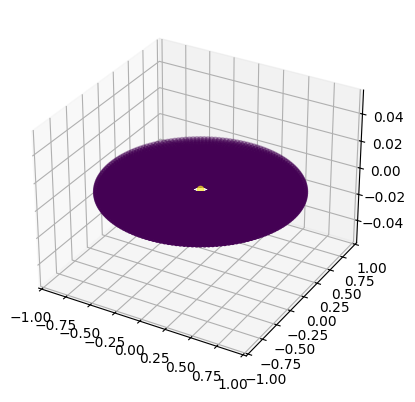

In [5]:
# plot the distribution of the particles
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(particles[:,0], particles[:,1], particles[:,2], cmap='viridis', c=particles[:,3])
plt.show()

14:02:37 - utils.particles - Half mass radius: 0.26777121151983396 for 4460th particle of 9913
14:02:37 - utils.particles - Number of particles within half mass radius: 4371 of 9913
14:02:37 - task2 - Mean interparticle distance: 0.026399750218803673
14:02:37 - utils.forces_basic - Computing forces for 9913 particles using n^2 algorithm (using softening=np.float64(0.026399750218803673))
14:02:37 - utils.forces_basic - Particle 0 done
14:02:39 - utils.forces_basic - Particle 5000 done
14:02:41 - utils.forces_basic - Computing forces for 9913 particles using spherical approximation
/home/remy/Documents/Uni/HS24/Computational Astrophysics/projects/nbody/utils/forces_basic.py:71: RuntimeWarning: invalid value encountered in scalar divide
  f = - m_current * m_enclosed / r_current**2
14:02:41 - utils.forces_basic - Particle 0 done
14:02:41 - utils.forces_basic - Particle 5000 done
14:02:42 - utils.forces_mesh - Computing forces for 9913 particles using mesh (using mapping=particle_to_cells_

Mesh information for Mesh
Total mapped mass: 11
Max cell value: 1.0
Min cell value: 0.0
Mean cell value: 1.1e-05


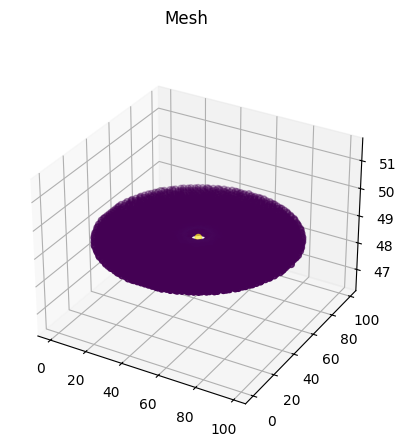

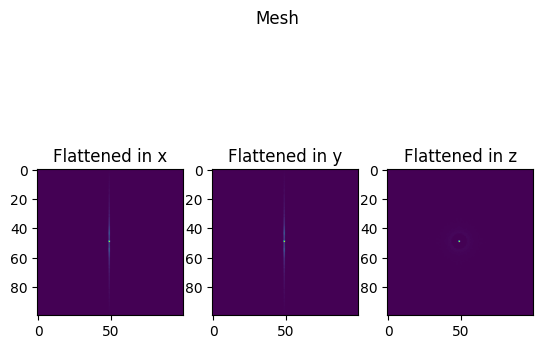

14:02:42 - utils.forces_mesh - Using mesh spacing: 0.018181818181818188
14:02:42 - utils.forces_mesh - Got k_square with: (100, 100, 100), 0.75 0.0
14:02:42 - utils.forces_mesh - Count of zeros: 1
14:02:42 - utils.forces_mesh - Got phi with: (100, 100, 100), -109999.75416785493


Mesh information for Mesh potential
Total mapped mass: -110000000000
Max cell value: -109999.75416785493
Min cell value: -110009.05961379336
Mean cell value: -110000.00000000001


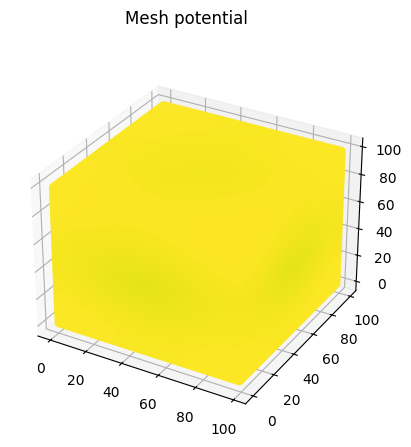

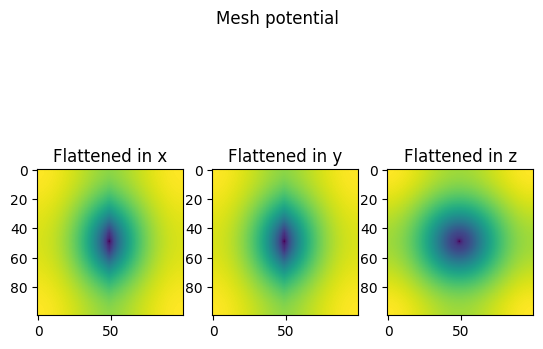

Mesh information for Mesh potential grad x
Total mapped mass: 7
Max cell value: 169.19632685316168
Min cell value: -169.18919774521777
Mean cell value: 7.173556951775168e-06


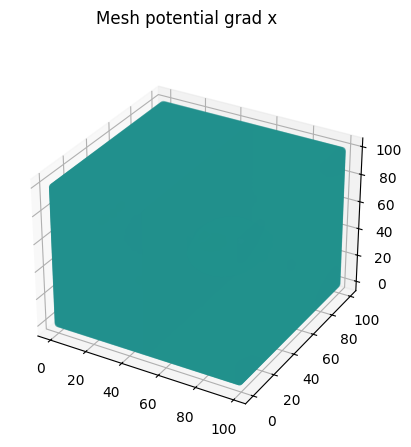

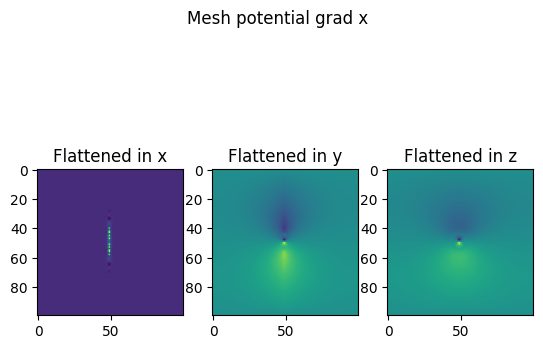

14:03:19 - utils.forces_mesh - Got phi_grad with: (3, 100, 100, 100), 171.6251363560513


In [6]:
### Direct N body force computation
epsilon = utils.mean_interparticle_distance(particles)
logger.info(f"Mean interparticle distance: {epsilon}")
f_nsquare = utils.n_body_forces(particles, G, epsilon)
f_analytical = utils.analytical_forces(particles)

mapping = utils.particle_to_cells_nn
mesh_size = 100
f_mesh = utils.mesh_forces_v2(particles, G, mesh_size, mapping)

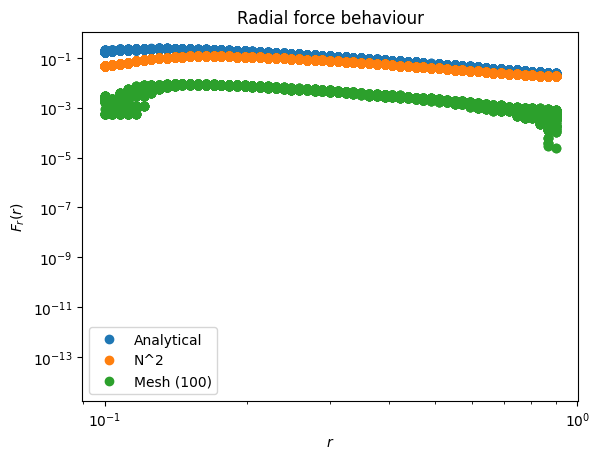

In [7]:
## Compare the mesh computation with the "straightforward" computations
r = np.linalg.norm(particles[:,:3], axis=1)

plt.figure()
plt.title('Radial force behaviour')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r$')
plt.ylabel('$F_r(r)$')

plt.plot(r, np.linalg.norm(f_analytical, axis=1), 'o', label="Analytical")
plt.plot(r, np.linalg.norm(f_nsquare, axis=1), 'o', label="N^2")
plt.plot(r, np.linalg.norm(f_mesh, axis=1), 'o', label=f"Mesh ({mesh_size})")

plt.legend()
plt.show()



In [ ]:
# load the particles in the format [x, y, z, vx, vy, vz, mass]
particles = points[:, [2, 3, 4, 5, 6, 7, 1]]

logger.info(f"Considering {particles.shape[0]} particles")
logger.info(f"Total mass: {np.sum(particles[:,6])}")

13:11:29 - __main__ - Considering 50010 particles
13:11:29 - __main__ - Total mass: 4622219.258999999


In [ ]:
# we can now integrate this system for a few steps
dt = 0.1
n_steps = 10
force_function = lambda x: utils.n_body_forces(x, G, epsilon)
y0, y_prime = utils.ode_setup(particles, force_function)

import scipy.integrate as spi

# integrate the system
sol = spi.odeint(y_prime, y0, np.arange(0, n_steps*dt, dt), atol=1e2)


13:11:29 - utils.integrate - Reshaped (50010, 7) to y0 with (300060,) and masses with (50010,)
13:11:29 - utils.integrate - y with shape (300060,)
13:11:29 - utils.integrate - Unstacked y into x with shape (50010, 3) and v with shape (50010, 3)
13:11:29 - utils.forces_basic - Computing forces for 50010 particles using n^2 algorithm (using softening=np.float64(0.021985731180436525))
13:11:29 - utils.forces_basic - Particle 0 done
13:11:50 - utils.forces_basic - Particle 5000 done
13:12:11 - utils.forces_basic - Particle 10000 done
13:12:34 - utils.forces_basic - Particle 15000 done


KeyboardInterrupt: 

In [ ]:
sol[4]

In [ ]:
# map the particles to a mesh
mapping_function = utils.particle_to_cells_nn
GRID_SIZE = 50
mesh, grid = utils.to_mesh(particles, GRID_SIZE, mapping_function)

utils.show_mesh_information(mesh, f"Initial mesh {GRID_SIZE=}")